

This data set consists of:

	1. 100,000 ratings (1-5) from 943 users on 1682 movies. 
	2. Each user has rated at least 20 movies. 
    3. Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998.
## Data Description


**Ratings**    -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a comma separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   


**Movie Information**   -- Information about the items (movies); this is a comma separated
              list of
              movie id | movie title | release date | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.



## Reading Dataset <a class="anchor" id="Reading-Dataset"></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [37]:
#Reading ratings file:
ratings = pd.read_csv('ratings.csv')

#Reading Movie Info File
movie_info = pd.read_csv('movie_info.csv')

In [38]:
ratings.shape, movie_info.shape

((100000, 4), (1682, 22))

In [9]:
ratings.head(5)

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
movie_info.head(5)

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-95,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-95,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-95,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-95,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Merging Movie information to ratings dataframe <a class="anchor" id="merge"></a>

The movie names are contained in a separate file. Let's merge that data with ratings and store it in ratings dataframe. The idea is to bring movie title information in ratings dataframe as it would be useful later on

In [10]:
ratings = ratings.merge(movie_info[['movie id','movie title']], how='left', left_on = 'movie_id', right_on = 'movie id')

In [11]:
ratings.shape

(100000, 6)

In [12]:
ratings.head(5)

,user_id,movie_id,rating,unix_timestamp,movie id,movie title
0,196,242,3,881250949,242,Kolya (1996)
1,186,302,3,891717742,302,L.A. Confidential (1997)
2,22,377,1,878887116,377,Heavyweights (1994)
3,244,51,2,880606923,51,Legends of the Fall (1994)
4,166,346,1,886397596,346,Jackie Brown (1997)


Lets also combine movie id and movie title separated by ': ' and store it in a new column named movie

In [13]:
ratings['movie'] = ratings['movie_id'].map(str) + str(': ') + ratings['movie title'].map(str)

In [14]:
ratings.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'movie id',
       'movie title', 'movie'],
      dtype='object')

Keeping the columns movie, user_id and rating in the ratings dataframe and drop all others

In [15]:
ratings = ratings.drop(['movie id', 'movie title', 'movie_id','unix_timestamp'], axis = 1)

In [16]:
ratings = ratings[['user_id','movie','rating']]

In [35]:
ratings.head()

,user_id,movie,rating
0,196,242: Kolya (1996),3
1,186,302: L.A. Confidential (1997),3
2,22,377: Heavyweights (1994),1
3,244,51: Legends of the Fall (1994),2
4,166,346: Jackie Brown (1997),1


##  Creating Train & Test Data & Setting Evaluation Metric <a class="anchor" id="eval"></a>
In order to test how well we do with a given rating prediction method, we would first need to define our train and test set, we will only use the train set to build different models and evaluate our model using the test set.

In [17]:
#Assign X as the original ratings dataframe
X = ratings.copy()

#Split into training and test datasets
X_train, X_test = train_test_split(X, shuffle= True, test_size = 0.25, random_state=42)

In [18]:
X_train.shape , X_test.shape

((75000, 3), (25000, 3))

In [19]:
#Function that computes the root mean squared error (or RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

##  Simple Baseline using average of all ratings <a class="anchor" id="simplebaseline"></a>

A simple baseline would give us the RMSE score that we get from just averaging all the available ratings and using it as predictions for all user movie pairs in the test set. This will also help us ensure that further when we use more complex techniques, we beat this score. If that is not the case maybe we need to change things.

In [20]:
#Define the baseline model to always return average of all available ratings
def baseline(user_id, movie):
    return X_train['rating'].mean()

In [44]:
#Function to compute the RMSE score obtained on the test set by a model
def rmse_score(model):
    
    #Construct a list of user-movie tuples from the test dataset
    id_pairs = zip(X_test['user_id'], X_test['movie'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['rating'])
    
    #Return the final RMSE score
    return rmse(y_true, y_pred)

In [45]:
rmse_score(baseline)

1.1244396573898978

## User based Collaborative filtering with simple user mean <a class="anchor" id="usermean"></a>
In User based CF we discussed steps for using weighted mean of similar users' ratings, let's first try just a simple average of all ratings given to a particular movie by all other users and make predictions. To do that first we will create the ratings matrix using pandas pivot_table function.

In [46]:
#Build the ratings matrix using pivot_table function
r_matrix = X_train.pivot_table(values='rating', index='user_id', columns='movie')

r_matrix.head()

movie,1000: Lightning Jack (1994),"1001: Stupids, The (1996)","1002: Pest, The (1997)",1003: That Darn Cat! (1997),1004: Geronimo: An American Legend (1993),"1005: Double vie de Véronique, La (Double Life of Veronique, The) (1991)",1006: Until the End of the World (Bis ans Ende der Welt) (1991),1007: Waiting for Guffman (1996),1008: I Shot Andy Warhol (1996),1009: Stealing Beauty (1996),...,992: Head Above Water (1996),993: Hercules (1997),"994: Last Time I Committed Suicide, The (1997)","995: Kiss Me, Guido (1997)","996: Big Green, The (1995)",997: Stuart Saves His Family (1995),998: Cabin Boy (1994),999: Clean Slate (1994),99: Snow White and the Seven Dwarfs (1937),9: Dead Man Walking (1995)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Often times, we will have most of the users rating on several movies, and most of the movies will only have some tens to hundreds of users to rate it. If we imagine this as a matrix where the rows represent the user ids, whereas the columns represent the movie id (i.e. item), then we have a very large matrix, but only with a small percentage of it filled in. Most of the entries in this matrix will be empty. This matrix, with most of the values missing or empty, will be called a *sparse matrix*. 

The task of a recommender system is often to predict the ratings on these missing entries in order to make recommendations to users on new items.

In [47]:
#User Based Collaborative Filter using Mean Ratings
def cf_user_mean(user_id, movie):
    
    #Check if movie exists in r_matrix
    if movie in r_matrix:
        
        #Compute the mean of all the ratings given to the movie
        mean_rating = r_matrix[movie].mean()
    
    else:
        #Default to average rating from the train set
        mean_rating = X_train['rating'].mean()
    
    return mean_rating

In [48]:
#Compute RMSE for the Mean model
rmse_score(cf_user_mean)

1.0224465207437918

We have improved significantly on RMSE score with this simple change, this clearly shows that there's value in using other users'ratings for making rating predictions for the movie.

## User based Collaborative filtering with similarity weighted mean <a class="anchor" id="userwmean"></a>
Now let's use pearson correlation and using these pearson correlations as weight try to predict the unknown ratings and check performance.

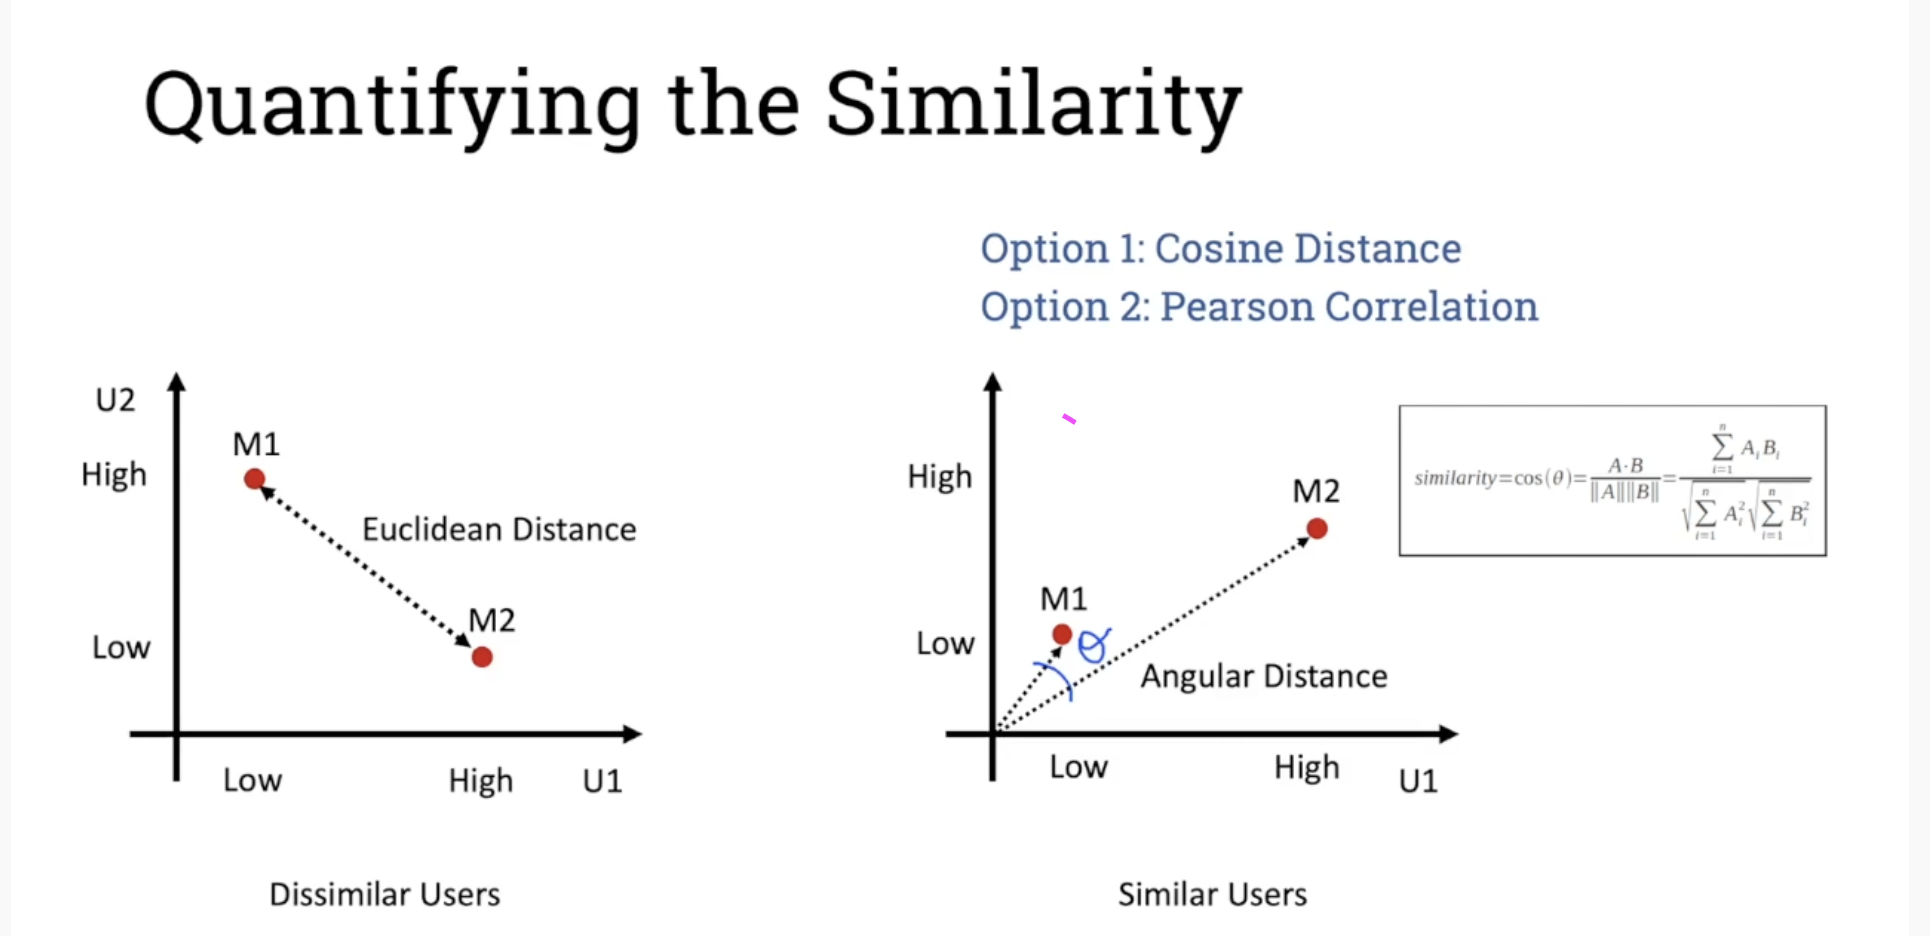

In [49]:
#Compute the Pearson Correlation using the ratings matrix with corr function from Pandas
pearson_corr = r_matrix.T.corr()
pearson_corr

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000e+00,-1.785714e-02,-2.758386e-01,-0.688247,0.343604,0.167618,0.356130,6.696235e-01,-0.301511,-0.264851,...,0.116327,-2.553770e-01,0.355677,0.000000,0.148884,0.787562,4.268828e-01,-2.166933e-16,-0.437241,0.102244
2,-1.785714e-02,1.000000e+00,9.930137e-17,0.577350,0.000000,0.411569,0.514376,0.000000e+00,0.500000,0.069338,...,0.104828,1.740777e-01,0.151887,0.081044,-0.095050,NaN,2.000817e-01,NaN,0.020546,0.583333
3,-2.758386e-01,9.930137e-17,1.000000e+00,0.207514,NaN,-0.265949,-0.735147,1.025978e-01,NaN,0.577350,...,NaN,NaN,-0.170561,-0.577350,-0.158777,NaN,-8.392497e-17,NaN,0.337100,NaN
4,-6.882472e-01,5.773503e-01,2.075143e-01,1.000000,NaN,NaN,-0.328897,5.773503e-01,NaN,NaN,...,NaN,NaN,NaN,NaN,0.866025,NaN,7.938842e-01,NaN,NaN,NaN
5,3.436041e-01,0.000000e+00,NaN,NaN,1.000000,0.237095,0.239475,6.360033e-01,NaN,-0.018112,...,0.121353,-5.000000e-01,0.297318,0.500000,0.678003,0.904534,-1.607116e-01,4.082483e-01,0.318559,0.475075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,7.875615e-01,NaN,NaN,NaN,0.904534,NaN,0.269680,NaN,NaN,NaN,...,0.500000,4.589122e-16,0.793925,NaN,0.133631,1.000000,NaN,NaN,NaN,-0.149071
940,4.268828e-01,2.000817e-01,-8.392497e-17,0.793884,-0.160712,0.038691,-0.087745,3.994298e-01,-0.500000,0.135675,...,-0.306059,7.385489e-01,-0.334021,-0.311925,0.816497,NaN,1.000000e+00,NaN,0.054910,0.348494
941,-2.166933e-16,NaN,NaN,NaN,0.408248,0.132453,NaN,-1.000000e+00,1.000000,0.500000,...,NaN,-2.581989e-01,0.160128,0.397360,-0.405046,NaN,NaN,1.000000e+00,-1.000000,-0.500000


In [50]:
#Convert into pandas dataframe 
pearson_corr = pd.DataFrame(pearson_corr, index=r_matrix.index, columns=r_matrix.index)

pearson_corr.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-1.785714e-02,-2.758386e-01,-0.688247,0.343604,0.167618,0.356130,0.669623,-3.015113e-01,-2.648507e-01,...,0.116327,-0.255377,3.556769e-01,0.000000,0.148884,0.787562,4.268828e-01,-2.166933e-16,-4.372411e-01,0.102244
2,-0.017857,1.000000e+00,9.930137e-17,0.577350,0.000000,0.411569,0.514376,0.000000,5.000000e-01,6.933752e-02,...,0.104828,0.174078,1.518871e-01,0.081044,-0.095050,NaN,2.000817e-01,NaN,2.054554e-02,0.583333
3,-0.275839,9.930137e-17,1.000000e+00,0.207514,NaN,-0.265949,-0.735147,0.102598,NaN,5.773503e-01,...,NaN,NaN,-1.705606e-01,-0.577350,-0.158777,NaN,-8.392497e-17,NaN,3.370999e-01,NaN
4,-0.688247,5.773503e-01,2.075143e-01,1.000000,NaN,NaN,-0.328897,0.577350,NaN,NaN,...,NaN,NaN,NaN,NaN,0.866025,NaN,7.938842e-01,NaN,NaN,NaN
5,0.343604,0.000000e+00,NaN,NaN,1.000000,0.237095,0.239475,0.636003,NaN,-1.811160e-02,...,0.121353,-0.500000,2.973177e-01,0.500000,0.678003,0.904534,-1.607116e-01,4.082483e-01,3.185591e-01,0.475075
6,0.167618,4.115688e-01,-2.659489e-01,NaN,0.237095,1.000000,0.145616,0.726489,7.537784e-02,3.627860e-01,...,-0.144049,-0.229416,4.193636e-01,0.296961,0.038835,NaN,3.869116e-02,1.324532e-01,1.098244e-01,0.078826
7,0.356130,5.143759e-01,-7.351470e-01,-0.328897,0.239475,0.145616,1.000000,0.291131,-1.075829e-01,2.729831e-01,...,-0.109807,-0.340307,5.053534e-01,0.592965,0.125578,0.269680,-8.774509e-02,NaN,4.660431e-01,0.361683
8,0.669623,0.000000e+00,1.025978e-01,0.577350,0.636003,0.726489,0.291131,1.000000,NaN,3.887408e-01,...,-0.110657,NaN,7.644708e-01,0.944911,0.877515,NaN,3.994298e-01,-1.000000e+00,-1.532253e-16,0.239229
9,-0.301511,5.000000e-01,NaN,NaN,NaN,0.075378,-0.107583,NaN,1.000000e+00,3.439900e-16,...,0.866025,NaN,0.000000e+00,0.755929,NaN,NaN,-5.000000e-01,1.000000e+00,NaN,NaN


Here we see that there are a lot of missing values, this could be due to no common ratings between 2 users or only 1 common rating, in both cases correlation will not be defined. 

We can replace all these missing values by 0 as this essentially means no correlation from the provided data between the 2 users

In [58]:
#Fill all the missing correlations with 0
pearson_cor = pearson_corr.fillna(0)

Basic assumption of Collaborative Filtering: Other user's opinion can be selected & aggregated in such a way to provide reasonable prediction of active user's preference

**Questions:**

**Q1)  How do we measure similarity ?**


Ans: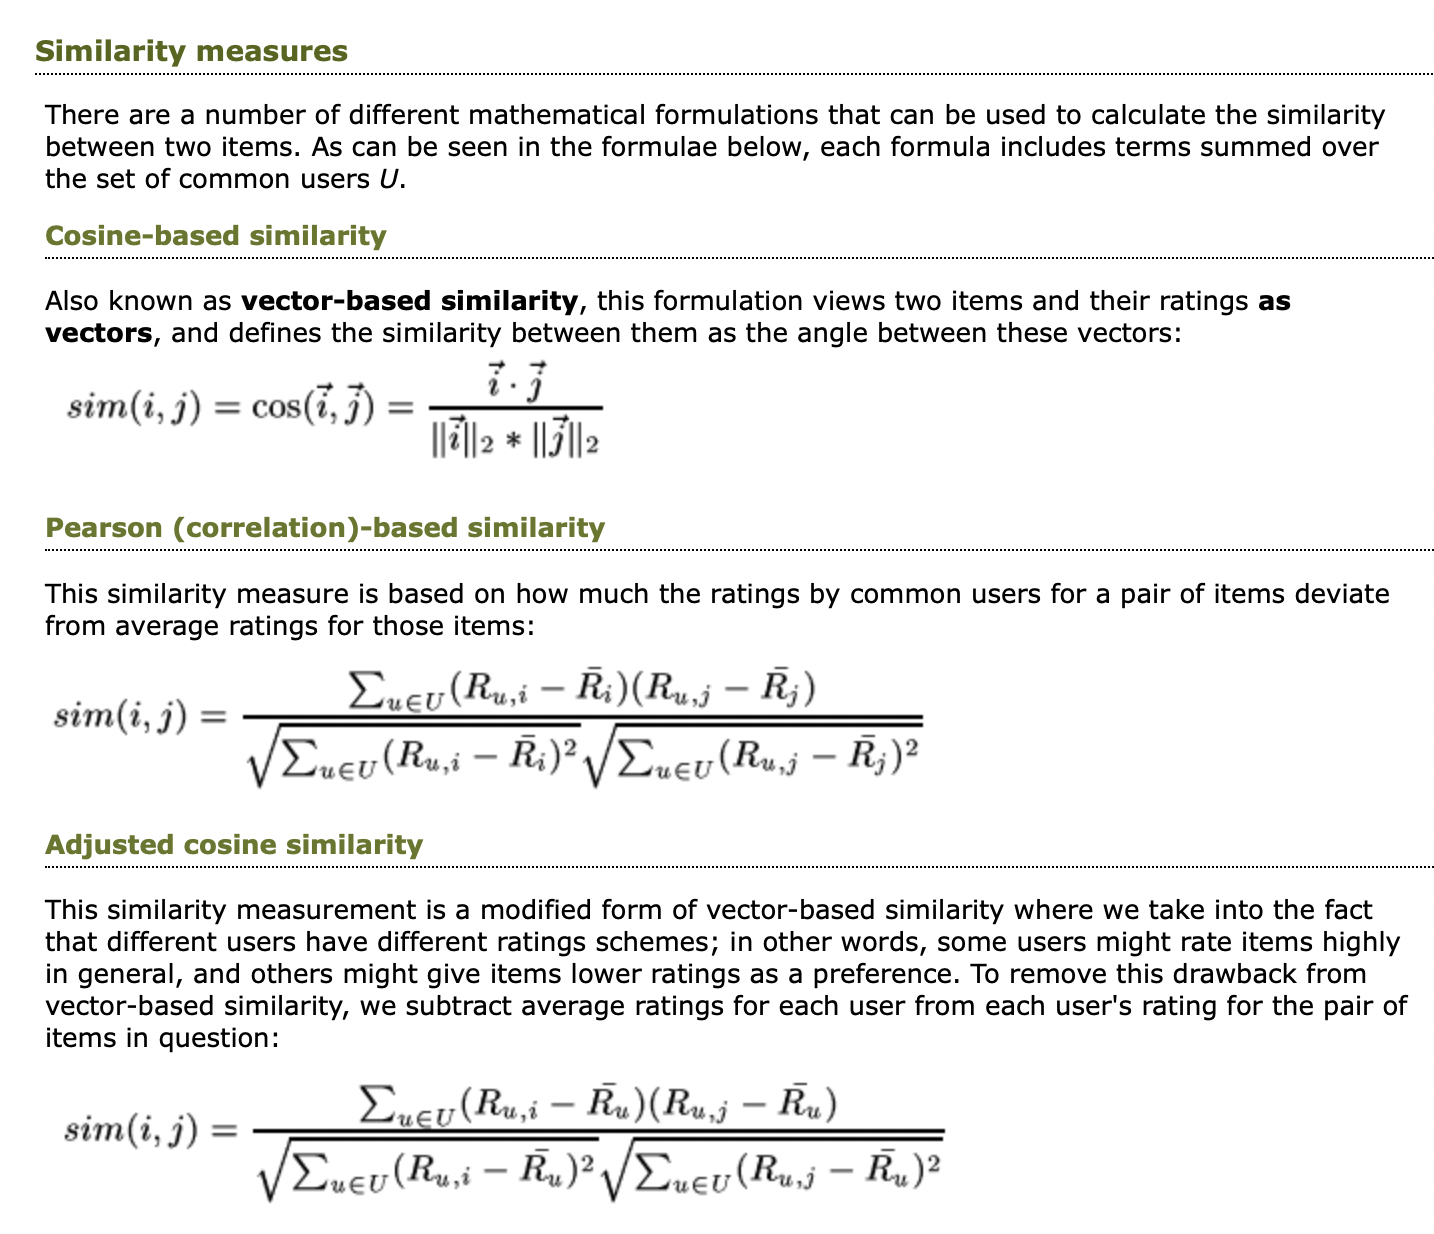
source: https://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html

Note: The two definitions look very similar, but be aware that:

In pearson correlation, the mean which subtracted is about the **particular item** itself (ratings from all users), mean(Ri)
In adjusted cosine correlation, the mean is about the **particular user** (ratings to all items), mean(Ru)


Now, we have the user user similarities stored in the matrix pearson_cor. We will define a function to predict the unknown ratings in the test set using user based collarborative filtering with simiarity as pearson correlation and using all neighbours with positive correlation. 

For each user movie pair:
1. Check if a movie is there in train set, if its not in that case we will just predict the mean rating as the predicted rating
2. Calculate the mean rating for the active user
3. Extract correlation values from matrix pearson_corr and sort it in decreasing order of correlation values
4. Keep only similarity scores for users with positive correlation with the active user
5. Drop all the users similar to active user but haven't rated the target movie
6. Do a check and predict mean rating if there are no similar users who have rated the target movie
7. Use the prediction formula to make rating predictions
<img src="pred_formula.png" style="width: 500px;"/>

ra and rb normalise the computation to adjust for different users' rating scales. 
for eg: Some users are very critical of the ratings they give, some never give below 3 stars out of 5 etc.

In [20]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(user_id, movie_id):
    
    #Check if movie_id exists in r_matrix
    if movie_id in r_matrix:
        
        #Mean rating for active user
        ra = r_matrix.loc[user_id].mean()

        #Get the similarity scores for the user in question with every other user
        sim_scores = pearson_corr[user_id].sort_values(ascending = False)
        
        # Keep similarity scores for users with positive correlation with active user
        sim_scores_pos = sim_scores[sim_scores > 0]
        
        #Get the user ratings for the movie in question
        m_ratings = r_matrix[movie_id][sim_scores_pos.index]
        
        #Extract the indices containing NaN in the m_ratings series (Users who have not rated the target movie)
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        # If there are no ratings from similar users we cannot use this method so we predict just 
        # the average rating of the movie else we use the prediction formula
        if len(m_ratings) == 0:
            #Default to average rating in the absence of ratings by similar users
            wmean_rating = r_matrix[movie_id].mean()
        else:   
            #Drop the corresponding correlation scores from the sim_scores series
            sim_scores_pos = sim_scores_pos.drop(idx)
            
            #Subtract average rating of each user from the rating (rbp - mean(rb))
            m_ratings = m_ratings - r_matrix.loc[m_ratings.index].mean(axis = 1)
            
            #Compute the final weighted mean using np.dot which is nothing but the product divided by sum of weights
            wmean_rating = ra + (np.dot(sim_scores_pos, m_ratings)/ sim_scores_pos.sum())
   
    else:
        #Default to average rating in the absence of any information on the movie in train set
        wmean_rating = X_train['rating'].mean()
    
    return wmean_rating

In [21]:
rmse_score(cf_user_wmean)

0.9568512581492972

We see that a weighted similarity approach has provided a major improvement in the performance. In the next video we will introduce a new library called the surprise library that can be called the Scikit Learn for recommender systems. It provides necessary tools to tune design parameters such as neighbourhood size similarity measures and much more

## Surprise Library

Surprise is an easy-to-use Python scikit learn like tool for recommender systems. Surprise library provides essential tools to build and experiment with various collaborative filtering methods. It provides support for:
1. Cross Validation
2. grid search
3. Built-in Datasets
4. Various Collaborative filtering methods

In [25]:
#Importing functions to be used in this notebook from Surprise Package
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNWithMeans

#you can read more about algotithms supported by surprise library here: 
#https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html#module-surprise.prediction_algorithms

To load a dataset from a pandas dataframe within Surprise, we will need the load_from_df() method. 
1. We will also need a `Reader` object and the `rating_scale` parameter must be specified. 
2. The dataframe here must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings in this order. 
3. Each row thus corresponds to a given rating

In [27]:
#Reader object to import ratings from X_train
#for this dataset, the scale of rating is from 1-5
reader = Reader(rating_scale=(1, 5))

#Storing Data in surprise format from X_train
data = Dataset.load_from_df(X_train[['user_id','movie','rating']], reader)

The `cross_validate()` function reports accuracy metric over a cross-validation procedure for a given set of parameters. If we want to know which parameter combination yields the best results, the `GridSearchCV` class comes to the rescue. 

Given a dict of parameters, this class exhaustively tries all the combinations of parameters and reports the best parameters for any accuracy measure (averaged over the different splits). It is heavily inspired from scikit-learn’s GridSearchCV.

# Grid Search for Neighbourhood size and similarity measure 

In [39]:
#Defining the parameter grid with k as the neighbourhood size & trying 2 similarity measures KNNwithMeans
#& 5 folds
param_grid = {"k":list(range(1,50,5)),
              "sim_options":{"name":["cosine","pearson"]},
             "min_k": list(range(1,50,4))}

#KNNWithMeans by default does user based collaborative filtering and here we are trying to find the best set of 
#parameters
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['rmse'], 
                  cv=5, 
                  n_jobs = -1)

#We fit the grid search on data to find out the best score
gs.fit(data)

#Printing the best score
print(gs.best_score['rmse'])

#Printing the best set of parameters
print(gs.best_params['rmse'])

we get {'k': 46, 'sim_options': {'name': 'pearson', 'user_based': True}, 'min_k': 5}

In [23]:
 {'k': 46, 'sim_options': {'name': 'pearson', 'user_based': True}, 'min_k': 5}

{'k': 46, 'sim_options': {'name': 'pearson', 'user_based': True}, 'min_k': 5}

In [40]:
#Defining similarity measure as per the best parameters
sim_options = {'name': 'pearson'}

#Fitting the model on train data
model = KNNWithMeans(k = 46, sim_options = sim_options)

#Build full trainset will essentially fit the knnwithmeans on the complete train set instead of a part of it
#like we do in cross validation
model.fit(data.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [23]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['movie'])

#Making predictions for test set using predict method from Surprise
[model.predict(uid = user, iid = movie) for (user, movie) in id_pairs]

[Prediction(uid=877, iid="381: Muriel's Wedding (1994)", r_ui=None, est=4.104196596682839, details={'actual_k': 38, 'was_impossible': False}),
 Prediction(uid=815, iid='602: American in Paris, An (1951)', r_ui=None, est=3.728344392131596, details={'actual_k': 32, 'was_impossible': False}),
 Prediction(uid=94, iid='431: Highlander (1986)', r_ui=None, est=3.556145118850295, details={'actual_k': 46, 'was_impossible': False}),
 Prediction(uid=416, iid="875: She's So Lovely (1997)", r_ui=None, est=3.331263765779608, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid=500, iid='182: GoodFellas (1990)', r_ui=None, est=3.9628659616218593, details={'actual_k': 46, 'was_impossible': False}),
 Prediction(uid=259, iid='1074: Reality Bites (1994)', r_ui=None, est=3.277829437744131, details={'actual_k': 46, 'was_impossible': False}),
 Prediction(uid=598, iid='286: English Patient, The (1996)', r_ui=None, est=3.534383641100695, details={'actual_k': 46, 'was_impossible': False}),
 Pred

We can see that unlike scikit learn, this doesn't just output a list of predictions but also details such as `actual_k` and `was_impossible`. 

1. `was_impossible`
Was impossible means there were no or not enough neighbours to make the predictions.

2. `actual_k`
For each of these algorithms, the actual number of neighbors that are aggregated to compute an estimation is necessarily less than or equal to 𝑘. 

Firstly, There might just not exist enough neighbors

Secondly, For predictions you only include neighbors for which the similarity measure is positive

For a given prediction, the actual number of neighbors can be retrieved in the 'actual_k' field of the details dictionary of the prediction.

If we want to check performance on test set, we need to extract predicted ratings from this which can be done by subseting this tuple

In [64]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['movie'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user, iid = movie)[3] for (user, movie) in id_pairs]

#Actual rating values for test set
y_true = X_test['rating']

# Checking performance on test set
rmse(y_true, y_pred)

0.9512496782880885

**A 15.5% reduction in rmse score from baseline model**

## Item based Collaborative filtering with simple item mean <a class="anchor" id="itemmean"></a>
Again in item based CF we discussed steps for using weighted mean of similar items' ratings, let's first try just a simple average of all ratings given by a particular user to all other movies and make predictions. To do that first we will create the ratings matrix using pandas pivot_table function.

In [65]:
#Item Based Collaborative Filter using Mean Ratings
def cf_item_mean(user_id, movie):
        
    #Compute the mean of all the ratings given by the user
    mean_rating = r_matrix.loc[user_id].mean()

    return mean_rating

In [66]:
#Compute RMSE for the Mean model
rmse_score(cf_item_mean)

1.044885130655045

The RMSE score that we get from this simple technique is lower than simple user mean for user based CF above by a small margin, now let us check item based collaborative filtering with weighted mean of most similar items

# Item based Collaborative filtering with similarity weighted mean

Now let's use cosine similarity and evaluate item based filtering by using similarity based weighted mean. Now cosine similarity varies from 0 to 1 and the function from sklearn that we are going to use does not work on missing values in the user item matrix so in order to create the item-item matrix we will fill all the missing values with 0. This means that for all movie user pairs where we don't have rating will accumulate a 0.

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [68]:
#Create a dummy ratings matrix with all null values imputed to 0
r_matrix_dummy = r_matrix.copy().fillna(0)

In [69]:
#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy.T, r_matrix_dummy.T)

#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.columns, columns=r_matrix.columns)

cosine_sim.head(5)

movie,1000: Lightning Jack (1994),"1001: Stupids, The (1996)","1002: Pest, The (1997)",1003: That Darn Cat! (1997),1004: Geronimo: An American Legend (1993),"1005: Double vie de Véronique, La (Double Life of Veronique, The) (1991)",1006: Until the End of the World (Bis ans Ende der Welt) (1991),1007: Waiting for Guffman (1996),1008: I Shot Andy Warhol (1996),1009: Stealing Beauty (1996),...,992: Head Above Water (1996),993: Hercules (1997),"994: Last Time I Committed Suicide, The (1997)","995: Kiss Me, Guido (1997)","996: Big Green, The (1995)",997: Stuart Saves His Family (1995),998: Cabin Boy (1994),999: Clean Slate (1994),99: Snow White and the Seven Dwarfs (1937),9: Dead Man Walking (1995)
movie,,,,,,,,,,,,,,,,,,,,,
1000: Lightning Jack (1994),1.000000,0.230365,0.102062,0.081111,0.0,0.000000,0.000000,0.073011,0.000000,0.000000,...,0.549972,0.054554,0.0,0.000000,0.218797,0.111187,0.140488,0.202031,0.090591,0.000000
"1001: Stupids, The (1996)",0.230365,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.193947,0.006421,0.040001,...,0.325785,0.056553,0.0,0.000000,0.000000,0.256137,0.000000,0.000000,0.105294,0.054170
"1002: Pest, The (1997)",0.102062,0.000000,1.000000,0.066227,0.0,0.000000,0.000000,0.000000,0.060690,0.000000,...,0.000000,0.000000,0.0,0.000000,0.029775,0.030261,0.191180,0.000000,0.013449,0.056888
1003: That Darn Cat! (1997),0.081111,0.000000,0.066227,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.056336,...,0.000000,0.000000,0.0,0.077557,0.236624,0.144296,0.395029,0.000000,0.042751,0.018838
1004: Geronimo: An American Legend (1993),0.000000,0.000000,0.000000,0.000000,1.0,0.065556,0.106504,0.053298,0.000000,0.056336,...,0.000000,0.053099,0.0,0.000000,0.011831,0.156320,0.000000,0.016387,0.056111,0.043326


Using cosine similarity we have estimated the similarity between each pair of items and we can use the same to check the most similar movies to each movie

In [70]:
#Checking movies most similar to Star Wars
cosine_sim['50: Star Wars (1977)'].sort_values(ascending = False)[1:6]

movie
181: Return of the Jedi (1983)          0.654124
172: Empire Strikes Back, The (1980)    0.520989
174: Raiders of the Lost Ark (1981)     0.520819
1: Toy Story (1995)                     0.513730
100: Fargo (1996)                       0.513665
Name: 50: Star Wars (1977), dtype: float64

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
C

Without feeding the information that return of the jedi and empire strikes back belong to the same universe as star wars, we see that cosine similarity has ranked these movies amongst the top. Quite interesting how just the user preferences can be used to find such hidden information.
Now, we have the item item similarities stored in the matrix cosine_sim. We will define a function to predict the unknown ratings in the test set using item based collarborative filtering with simiarity as cosine and using all the ratings of other items. For each user movie pair:
Check if a movie is there in train set, if its not in that case we will just predict the mean rating as the predicted rating
Extract cosine similarity values from matrix cosine_sim
Drop all the unrated items as they cannot contribute to the prediction from both similarity scores and ratings
Use the prediction formula to make rating predictions

In [71]:
#Item Based Collaborative Filter using Weighted Mean Ratings
def cf_item_wmean(user_id, movie_id):
    
    #Check if movie_id exists in r_matrix
    if movie_id in r_matrix:
        
        #Get the similarity scores for the item in question with every other item
        sim_scores = cosine_sim[movie_id]
        
        #Get the movie ratings for the user in question
        m_ratings = r_matrix.loc[user_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series (removing unrated items)
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        #Default to average rating in the absence of any information on the movie in train set
        wmean_rating = X_train['rating'].mean()
    
    return wmean_rating

In [72]:
rmse_score(cf_item_wmean)

1.0166073087455623

We see that not much has improved here, so we could go ahead and try to constraint the neighbourhood as well as use different similarity measures such as adjusted cosine similarity to improve

In [41]:
#Defining the parameter grid with k as the neighbourhood size & trying 2 similarity measures KNNwithMeans
#& 5 folds, we also use user_based as True and false to try both user based and item based collaborative filtering
#and check which performs better
param_grid = {"k":list(range(1,50,5)),
              "sim_options":{"name":["cosine","pearson"],
                'user_based': [True,False]},
             "min_k": list(range(1,50,4))}

#Trying to find the best set of hyperparameters using Grid Search
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['rmse'], 
                  cv=5, 
                  n_jobs = -1)

#We fit the grid search on data to find out the best score
gs.fit(data)

#Printing the best score
print(gs.best_score['rmse'])

#Printing the best set of parameters
print(gs.best_params['rmse'])

we get {'k': 46, 'sim_options': {'name': 'cosine', 'user_based': False}, 'min_k': 1}

In [42]:
{'k': 46, 'sim_options': {'name': 'cosine', 'user_based': False}, 'min_k': 1}

{'k': 46, 'sim_options': {'name': 'cosine', 'user_based': False}, 'min_k': 1}

This is good. We have got some improvement with item based filtering, now lets check the same on the test data. Note that knnwithmeans ensure that we are using ratings normalized by average user ratings which is what adjusted cosine similarity offers.
Now using the best parameters we can fit the model on complete dataset and check performance on the test set

# Fitting Model on complete train set & checking performance on test data

In [74]:
#Defining similarity measure as per the best parameters
sim_options = {'name': 'cosine', 'user_based': False}

#Fitting the model on train data
model = KNNWithMeans(k = 46, sim_options = sim_options)

#Build full trainset will essentially fits the knnwithmeans on the complete train set instead of a part of it
#like we do in cross validation
model.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [75]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['movie'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user, iid = movie)[3] for (user, movie) in id_pairs]

#Actual rating values for test set
y_true = X_test['rating']

# Checking performance on test set
rmse(y_true, y_pred)

0.9451846317639762

**A 16% reduction in rmse score from baseline model**

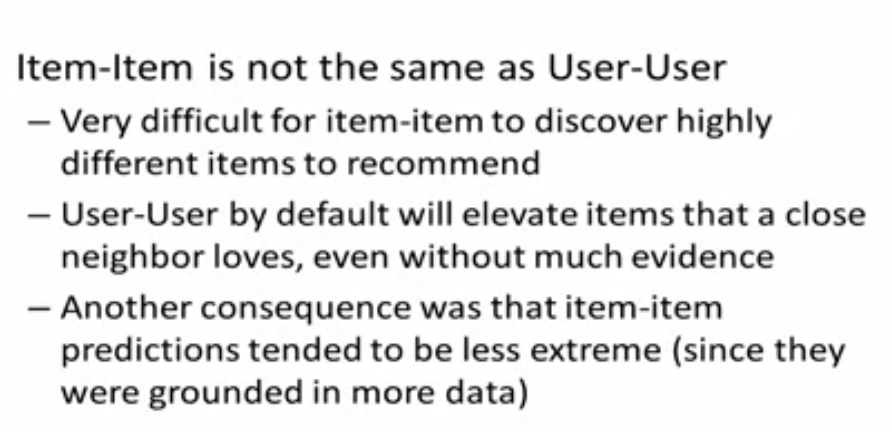

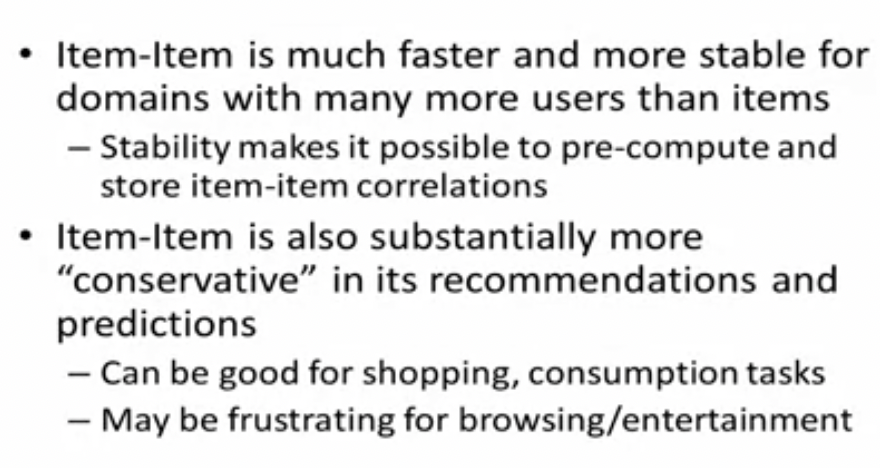